
In this second part of the lab, we'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

The list of labels:

0 : 'T-Shirt'

---


1 : 'Trouser'

---


2 : 'Pullover'

---


3 : 'Dress'

---


4 : 'Coat'

---


5 : 'Sandal'

---


6 : 'Shirt'

---


7 : 'Sneaker'

---


8 : 'Bag'

---


9 : 'Ankle Boot'

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping, dropout, and L2 weight regularization.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normaliz (e((0.5, ), (0.5, ))])  #0.5 mean and 0.5 std
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:04, 5906984.45it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 40420.65it/s]                           
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:02, 1706438.75it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


8192it [00:00, 15187.18it/s]            

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


Lets take a look to the mini-batch size and plot a sample.

In [ ]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

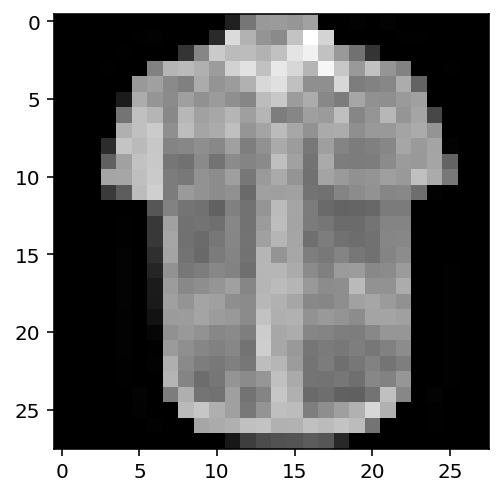

In [ ]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and I) evaluate train/test performance

In [ ]:
# Your code here

class NNmodel(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        self.output1 = nn.Linear(dimx,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)
        self.output4 = nn.Linear(hidden3,nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x=self.output1(x)
        x=self.relu(x)
        x=self.output2(x)
        x=self.relu(x)
        x=self.output3(x)
        x=self.relu(x)
        x=self.output4(x)
        x=self.logsoftmax(x)
        return x
      
      
class NNmodel_extended(NNmodel):
  
  def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):

        # Your code here
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `Multi_LR`!
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        
  def trainloop(self,trainloader):
    # Optimization Loop
    for e in range(int(self.epochs)):
        # Random data permutation at each epoch
        running_loss = 0.
        for images, labels in trainloader:              
            self.optim.zero_grad()  #TO RESET GRADIENTS!
            out = self.forward(images.view(images.shape[0], -1))
            loss = self.criterion(out,labels)
            running_loss += loss.item()
            loss.backward()
            self.optim.step()
        self.loss_during_training.append(running_loss/len(trainloader))
        if(e % 10 == 0): # Every 10 epochs

            print("Training loss after %d epochs: %f" 
                  %(e,self.loss_during_training[-1]))

  def eval_performance(self,dataloader):
      loss = 0
      accuracy = 0
      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():
          for images,labels in dataloader:
              # Your code here
              probs = self.forward(images.view(images.shape[0], -1))
              top_p, top_class = probs.topk(1, dim=1)
              equals = (top_class == labels.view(images.shape[0], 1)) 
              accuracy += torch.mean(equals.type(torch.FloatTensor))
          return accuracy/len(dataloader)
    
    


In [ ]:
my_NN = NNmodel_extended(dimx=784,hidden1=256, hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_NN.trainloop(trainloader)

train_performance = my_NN.eval_performance(trainloader)

test_performance = my_NN.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Training loss after 0 epochs: 0.518807
Training loss after 10 epochs: 0.219627
Training loss after 20 epochs: 0.148379
Train Accuracy 0.965035
Test Accuracy 0.890227


Text(0, 0.5, 'Loss')

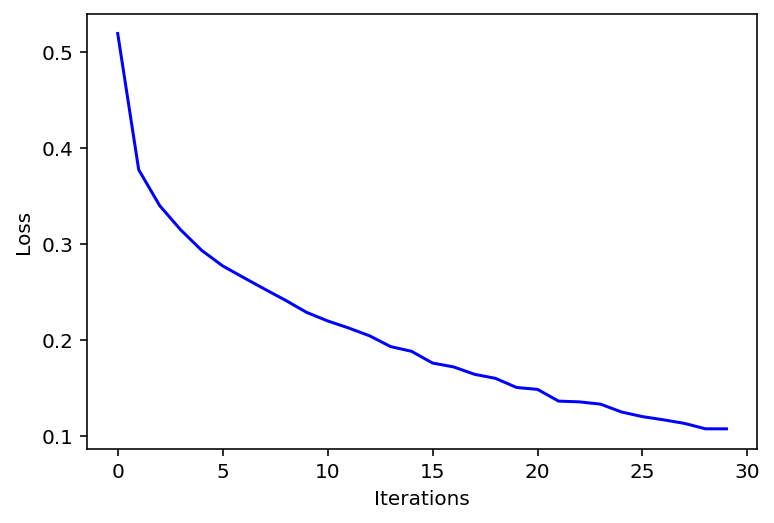

In [ ]:
plt.plot(my_NN.loss_during_training,'-b',label='Cross Entropy Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [ ]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]



> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs

In [ ]:
#Your code here

class NNmodel_extended_validation(NNmodel_extended):
  def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,epochs,lr)  #To initialize `Multi_LR`!
        self.valid_loss_during_training = [] 
  
  def trainloop(self,trainloader,validloader):

    # Optimization Loop
    for e in range(int(self.epochs)):
        # Random data permutation at each epoch
        running_loss = 0.
        valid_loss = 0.
        for images, labels in trainloader:              
            self.optim.zero_grad()  #TO RESET GRADIENTS!
            out = self.forward(images.view(images.shape[0], -1))
            loss = self.criterion(out,labels)
            running_loss += loss.item()
            #Your code here
            loss.backward()
            self.optim.step()
            
        with torch.no_grad():    
          for images, labels in validloader:
              out_val = self.forward(images.view(images.shape[0], -1))
              loss_val = self.criterion(out_val,labels)
              valid_loss += loss_val.item()
        self.loss_during_training.append(running_loss/len(trainloader))
        self.valid_loss_during_training.append(valid_loss/len(validloader))

        if(e % 10 == 0): # Every 10 epochs

            print("Training loss after %d epochs: %f" 
                  %(e,self.loss_during_training[-1]))
            print("Validation Training loss after %d epochs: %f" 
                  %(e,self.valid_loss_during_training[-1]))
            
            
  def eval_performance(self,dataloader):
  # Your code here
    loss = 0
    accuracy = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for images,labels in dataloader:
            # Your code here
            probs = self.forward(images.view(images.shape[0], -1))
            top_p, top_class = probs.topk(1, dim=1)
            equals = (top_class == labels.view(images.shape[0], 1)) 
            accuracy += torch.mean(equals.type(torch.FloatTensor))
        return accuracy/len(dataloader)
        



In [ ]:
my_NN_valid = NNmodel_extended_validation(dimx=784,hidden1=256, hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)
my_NN_valid.trainloop(trainloader,validloader)



Training loss after 0 epochs: 0.543357
Validation Training loss after 0 epochs: 0.423294
Training loss after 10 epochs: 0.224491
Validation Training loss after 10 epochs: 0.355849
Training loss after 20 epochs: 0.146632
Validation Training loss after 20 epochs: 0.406021


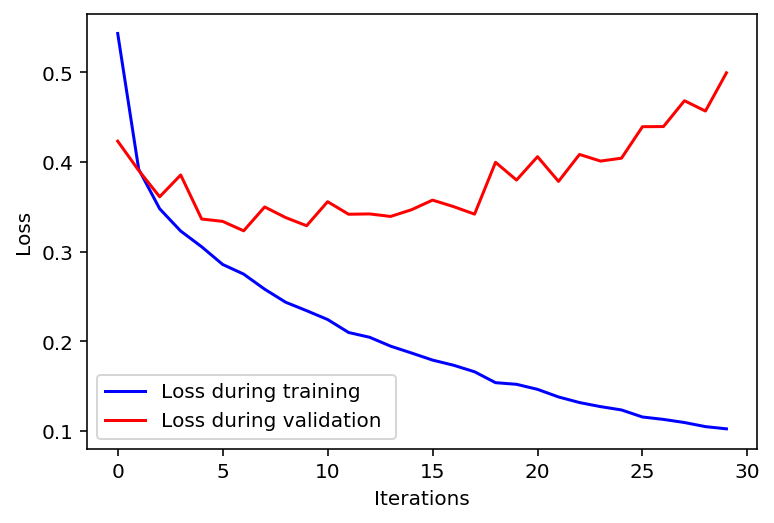

In [ ]:
plt.plot(my_NN_valid.loss_during_training,'-b',label='Loss during training')
plt.plot(my_NN_valid.valid_loss_during_training,'-r',label='Loss during validation ')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

In [ ]:
#Your code here

my_NN = NNmodel_extended_validation(dimx=784,hidden1=256, hidden2=128,hidden3=64,nlabels=10,epochs=10,lr=1e-3)
my_NN.trainloop(trainloader,validloader)

train_performance = my_NN.eval_performance(trainloader)
validTrain_performance = my_NN.eval_performance(validloader)
test_performance = my_NN.eval_performance(testloader)

print("Train Accuracy %f" %(train_performance))
print("Validation Accuracy %f" %(validTrain_performance))
print("Test Accuracy %f" %(test_performance))



Training loss after 0 epochs: 0.545978
Validation Training loss after 0 epochs: 0.461693
Train Accuracy 0.922630
Validation Accuracy 0.884353
Test Accuracy 0.881668


## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modified the extended clases to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [ ]:
#Your code here


class NNmodel_regularization(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()
        self.output1 = nn.Linear(dimx,hidden1)
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)
        self.output4 = nn.Linear(hidden3,nlabels)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        self.dropout = nn.Dropout(p=prob)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x=self.output1(x)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.output2(x)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.output3(x)
        x=self.relu(x)
        x=self.dropout(x)

        x=self.output4(x)
        x=self.logsoftmax(x)
        
        return x

In [ ]:
#Your code here

class NNmodel_extended_validation_regul(NNmodel_regularization):
  
  def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001,prob=0.2):
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,prob)  #To initialize `Multi_LR`!
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()              
        self.loss_during_training = [] 
        self.valid_loss_during_training = [] 
        self.prob=prob
        
  def trainloop(self,trainloader,validloader):
    # Optimization Loop
    for e in range(int(self.epochs)):
        # Random data permutation at each epoch
        running_loss = 0.
        valid_loss = 0.
        for images, labels in trainloader:              
            self.optim.zero_grad()  #TO RESET GRADIENTS!
            out = self.forward(images.view(images.shape[0], -1))
            loss = self.criterion(out,labels)
            running_loss += loss.item()
            loss.backward()
            self.optim.step()
        with torch.no_grad():   
          self.eval()
          for images, labels in validloader:
              out_val = self.forward(images.view(images.shape[0], -1))
              loss_val = self.criterion(out_val,labels)
              valid_loss += loss_val.item()
        self.train()
      
        self.loss_during_training.append(running_loss/len(trainloader))
        self.valid_loss_during_training.append(valid_loss/len(validloader))

        if(e % 10 == 0): # Every 10 epochs

            print("Training loss after %d epochs: %f" 
                  %(e,self.loss_during_training[-1]))
            print("Validation Training loss after %d epochs: %f" 
                  %(e,self.valid_loss_during_training[-1]))
            

  def eval_performance(self,dataloader):
   
    loss = 0
    accuracy = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for images,labels in dataloader:
            # Your code here
            probs = self.forward(images.view(images.shape[0], -1))
            top_p, top_class = probs.topk(1, dim=1)
            equals = (top_class == labels.view(images.shape[0], 1)) 
            accuracy += torch.mean(equals.type(torch.FloatTensor))
        return accuracy/len(dataloader)




In [ ]:
            
my_NN_dropout = NNmodel_extended_validation_regul(dimx=784,hidden1=256, hidden2=128,hidden3=64,nlabels=10,epochs=50,lr=1e-3,prob=0.2)
my_NN_dropout.trainloop(trainloader,validloader)



Training loss after 0 epochs: 0.637271
Validation Training loss after 0 epochs: 0.494417
Training loss after 10 epochs: 0.300229
Validation Training loss after 10 epochs: 0.336663
Training loss after 20 epochs: 0.249140
Validation Training loss after 20 epochs: 0.328626
Training loss after 30 epochs: 0.218834
Validation Training loss after 30 epochs: 0.337725
Training loss after 40 epochs: 0.196202
Validation Training loss after 40 epochs: 0.328817


In [ ]:
train_performance = my_NN_dropout.eval_performance(trainloader)
validTrain_performance = my_NN_dropout.eval_performance(validloader)
test_performance = my_NN_dropout.eval_performance(testloader)

print ("Performance with dropout, p=0.2")
print("Train Accuracy %f" %(train_performance))
print("Validation Accuracy %f" %(validTrain_performance))
print("Test Accuracy %f" %(test_performance))


Performance with dropout, p=0.2
Train Accuracy 0.934637
Validation Accuracy 0.878945
Test Accuracy 0.876493


Text(0, 0.5, 'Loss')

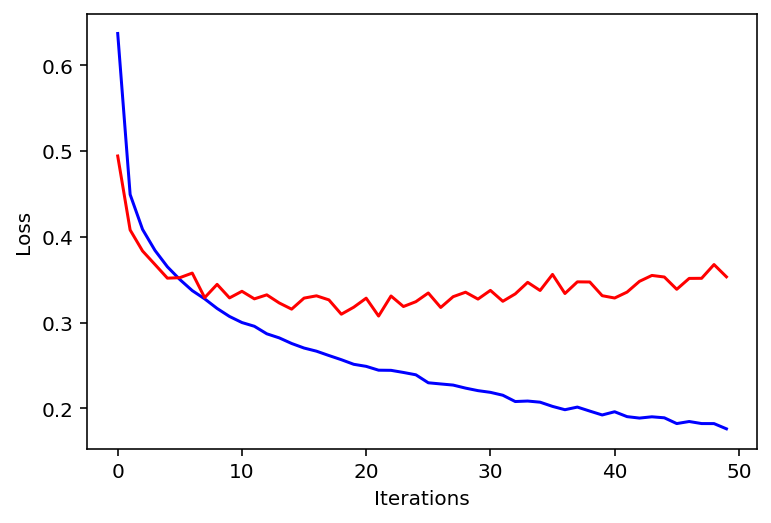

In [ ]:
plt.plot(my_NN_dropout.loss_during_training,'-b',label='Loss during training')
plt.plot(my_NN_dropout.valid_loss_during_training,'-r',label='Loss during validation training')
plt.xlabel('Iterations')
plt.ylabel('Loss')

**COMPARISON BETWEEN EARLY STOPPING AND DROPOUT:**

First, we can see the obtained accuracy in case of using early-stopping technique (with 10 epochs) :

*   Train Accuracy 0.922630
*   Validation Accuracy 0.884353
*   Test Accuracy 0.881668

On the other hand, we can see that the accuracy obtained in case of using dropout (p =0.2) is: 

*   Train Accuracy 0.934637
*   Validation Accuracy 0.878945
*   Test Accuracy 0.876493



Despite of using dropout, it's still needed early-stopping, since validation loss starts to grow up at a certain point. Because of that, we reduce the number of epochs to 15. 
Then, in the following picture we can see that the validation loss doesn't grow at all.


**DROPOUT (P=0.2) AND EARLY STOPPING WITH EPOCHS=15**

Training loss after 0 epochs: 0.637246
Validation Training loss after 0 epochs: 0.449661
Training loss after 10 epochs: 0.304797
Validation Training loss after 10 epochs: 0.328141
Performance with dropout (p=0.2) and early stopping
Train Accuracy 0.899237
Validation Accuracy 0.869215
Test Accuracy 0.865545


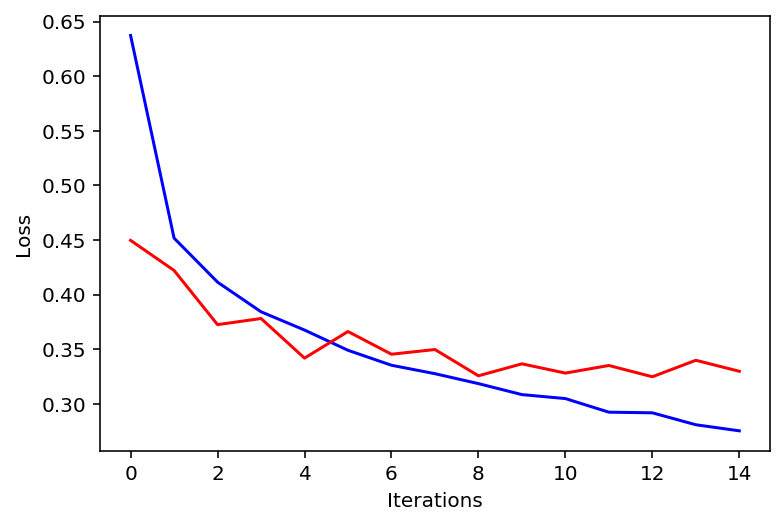

In [ ]:
my_NN_dropout_early = NNmodel_extended_validation_regul(dimx=784,hidden1=256, hidden2=128,hidden3=64,nlabels=10,epochs=15,lr=1e-3,prob=0.2)
my_NN_dropout_early.trainloop(trainloader,validloader)
plt.plot(my_NN_dropout_early.loss_during_training,'-b',label='Loss during training')
plt.plot(my_NN_dropout_early.valid_loss_during_training,'-r',label='Loss during validation training')
plt.xlabel('Iterations')
plt.ylabel('Loss')

train_performance2 = my_NN_dropout_early.eval_performance(trainloader)
validTrain_performance2 = my_NN_dropout_early.eval_performance(validloader)
test_performance2 = my_NN_dropout_early.eval_performance(testloader)
print ("Performance with dropout (p=0.2) and early stopping")
print("Train Accuracy %f" %(train_performance2))
print("Validation Accuracy %f" %(validTrain_performance2))
print("Test Accuracy %f" %(test_performance2))


Now, we try with different probabilities for Dropout technique (and after reducing number of epochs to 15)


**Drop of 30% of activations in layer**

Training loss after 0 epochs: 0.696299
Validation Training loss after 0 epochs: 0.484952
Training loss after 10 epochs: 0.340100
Validation Training loss after 10 epochs: 0.330519
Performance with dropout (p=0.3) and early stopping
Train Accuracy 0.889537
Validation Accuracy 0.869371
Test Accuracy 0.859076


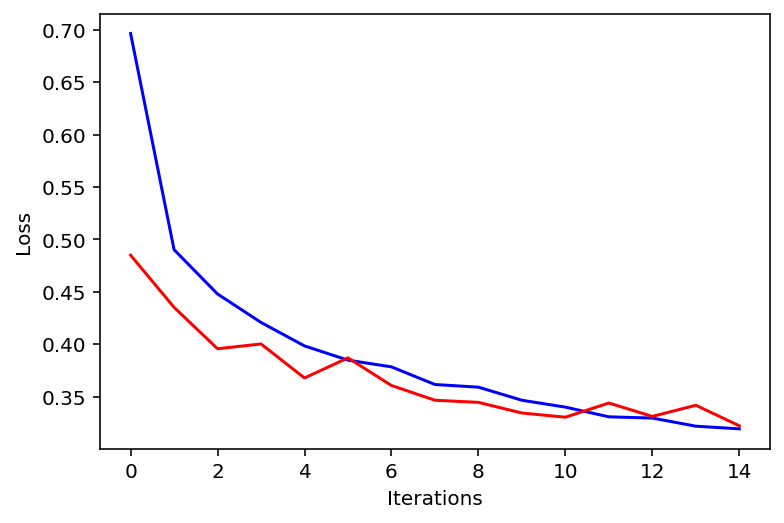

In [ ]:
my_NN_dropout03 = NNmodel_extended_validation_regul(dimx=784,hidden1=256, hidden2=128,hidden3=64,nlabels=10,epochs=15,lr=1e-3,prob=0.3)
my_NN_dropout03.trainloop(trainloader,validloader)

plt.plot(my_NN_dropout03.loss_during_training,'-b',label='Loss during training')
plt.plot(my_NN_dropout03.valid_loss_during_training,'-r',label='Loss during validation training')
plt.xlabel('Iterations')
plt.ylabel('Loss')

train_performance3 = my_NN_dropout03.eval_performance(trainloader)
validTrain_performance3 = my_NN_dropout03.eval_performance(validloader)
test_performance3 = my_NN_dropout03.eval_performance(testloader)
print ("Performance with dropout (p=0.3) and early stopping")
print("Train Accuracy %f" %(train_performance3))
print("Validation Accuracy %f" %(validTrain_performance3))
print("Test Accuracy %f" %(test_performance3))




In this case, it's remarkable that the perfomance in training decreases a bit, while the validation performance increases. This behavior is quite logical, since we are droping more activations in layer so our model turns out in a more generalizable model.

**Drop of 10% of activations in layer**

Training loss after 0 epochs: 0.587692
Validation Training loss after 0 epochs: 0.448784
Training loss after 10 epochs: 0.267593
Validation Training loss after 10 epochs: 0.325176
Performance with dropout (p=0.1) and early stopping
Train Accuracy 0.910134
Validation Accuracy 0.875643
Test Accuracy 0.869825


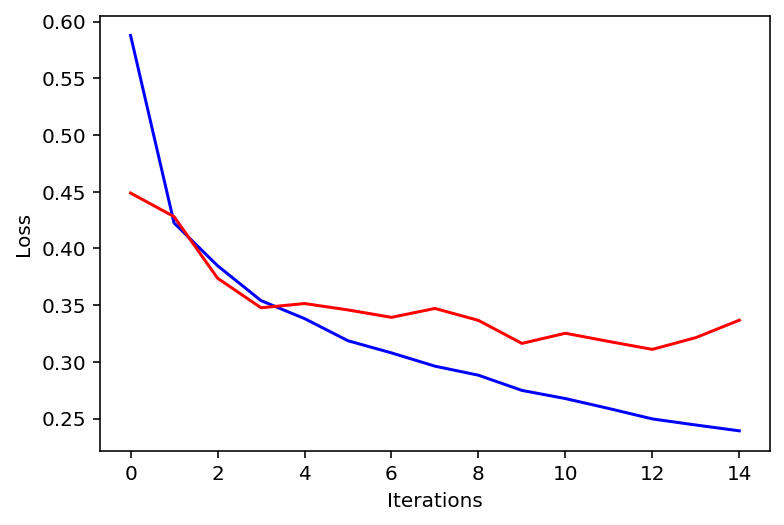

In [ ]:

my_NN_dropout01 = NNmodel_extended_validation_regul(dimx=784,hidden1=256, hidden2=128,hidden3=64,nlabels=10,epochs=15,lr=1e-3,prob=0.1)
my_NN_dropout01.trainloop(trainloader,validloader)
plt.plot(my_NN_dropout01.loss_during_training,'-b',label='Loss during training')
plt.plot(my_NN_dropout01.valid_loss_during_training,'-r',label='Loss during validation training')
plt.xlabel('Iterations')
plt.ylabel('Loss')

train_performance1 = my_NN_dropout01.eval_performance(trainloader)
validTrain_performance1 = my_NN_dropout01.eval_performance(validloader)
test_performance1 = my_NN_dropout01.eval_performance(testloader)
print ("Performance with dropout (p=0.1) and early stopping")
print("Train Accuracy %f" %(train_performance1))
print("Validation Accuracy %f" %(validTrain_performance1))
print("Test Accuracy %f" %(test_performance1))


In this case, it's remarkable that the train accuracy increases (since we are overfitting a bit more) but the validation performance keeps more or less in the same value.
